<a href="https://colab.research.google.com/github/Yulian302/Brain-Tumor-Classification-from-MRI-images-TL-/blob/main/MRI_ImRe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Axial plane example:<br><br>
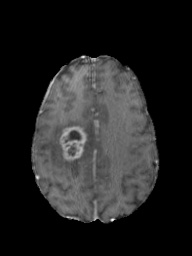

<b>Coronal plane example:<br><br>
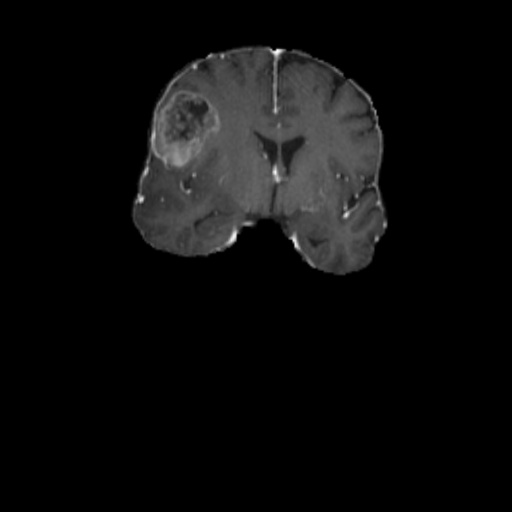

<b>Sagittal plane example:<br><br>
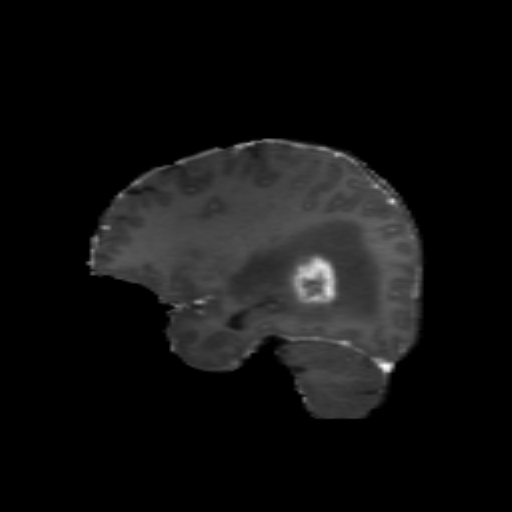

In [ ]:
#@title Mount Google Drive
from google.colab import drive
mount_drive = True #@param {type:'boolean'}
#@markdown <b>Check to mount Google Drive
mount_folder = "Mount" #@param {type:'string'}
if mount_drive:
    drive = drive.mount(mount_folder if mount_folder else 'Drive')
#@markdown Mounted folder name(if needed)

Mounted at Mount


In [ ]:
#@title Import neccessary libraries
!pip install elapsedtimer
import pandas as pd
import random
import tensorflow as tf
from keras.layers import Dense,Dropout,MaxPooling2D,MaxPool2D,Conv2D,Flatten,GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from keras import Input,Sequential
import cv2
from PIL import Image,ImageEnhance
import sys
import shutil
import zipfile
import torch
from sklearn.metrics import accuracy_score,roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from keras.applications import VGG16
import urllib.request
from IPython.display import Image, display
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import glob
from PIL.Image import fromarray
import time
from tensorflow.keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping,TensorBoard,ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from elapsedtimer import ElapsedTimer

In [ ]:
#@title Dataset loading (Image Generator)
#@markdown <b><h1>  Classification Model (VGG16)
train_dir_path_cl  = "/content/Mount/MyDrive/coursework/Data/Datasets/Training" #@param {type:'string'}
test_dir_path_cl = "/content/Mount/MyDrive/coursework/Data/Datasets/Testing" #@param {type:'string'}
#@markdown <b><h1> Classification Model (EfficientNetB0)
train_dir_path_cl_ef  = "/content/Mount/MyDrive/coursework/Data/Datasets/EfficientNet/Training" #@param {type:'string'}
test_dir_path_cl_ef = "/content/Mount/MyDrive/coursework/Data/Datasets/EfficientNet/Testing" #@param {type:'string'}
output_folder = '/content/Mount/MyDrive/coursework/Models/YoloV5OD/output_models' #@param {type:'string'}
#@markdown <b><h4> Directiories that contain training and testing images
class_names = "glioma,meningioma,notumor,pituitary" #@param {type:'string'}
#@markdown <b>Comma-separated values for class names of dataset (if needed)
class_names = class_names.split(',')
batch_size = 16 #@param {type:'number'}
#@markdown <b>Batch size (choose lower if OUT OF MEMORY)

img_width=512 #@param {type:'number'}
img_height=512 #@param {type:'number'}
#@markdown <b>Image width and height

size=(img_height,img_width)


def augment_img(img):
    img = fromarray(np.uint8((img * 255).astype(np.uint8)))
    img = ImageEnhance.Brightness(img).enhance(random.uniform(0.8,1.2))
    img = ImageEnhance.Contrast(img).enhance(random.uniform(0.8,1.2))
    return np.asarray(img, dtype=np.float32) / 255.0

if not train_dir_path_cl or not test_dir_path_cl:
    raise Exception("Dir paths are empty!")
else:
    print(f'Classes: {class_names}')
    train_datagen_cl = ImageDataGenerator(
        preprocessing_function=augment_img
        )

    test_datagen_cl = ImageDataGenerator(
        preprocessing_function=augment_img
    )

    train_datagen_cl_ef = ImageDataGenerator(
        preprocessing_function=augment_img,
        )

    test_datagen_cl_ef = ImageDataGenerator(
        preprocessing_function=augment_img
    )


    training_generator_cl = train_datagen_cl.flow_from_directory(
        directory=train_dir_path_cl,
        batch_size=batch_size,
        target_size=size,
        color_mode='rgb',
        class_mode='sparse',
        shuffle=True,
    )
    print('Training images loaded...')

    validation_generator_cl = test_datagen_cl.flow_from_directory(
        directory=test_dir_path_cl,
        batch_size=batch_size,
        target_size=size,
        color_mode='rgb',
        class_mode='sparse',
        shuffle=True,
    )

    training_generator_eff = train_datagen_cl_ef.flow_from_directory(
        directory=train_dir_path_cl,
        batch_size=batch_size,
        target_size=size,
        color_mode='rgb',
        class_mode='sparse',
        shuffle=True,
    )

    validation_generator_eff = test_datagen_cl_ef.flow_from_directory(
        directory=test_dir_path_cl,
        batch_size=batch_size,
        target_size=size,
        color_mode='rgb',
        class_mode='sparse',
        shuffle=True,
    )

    print('Testing images loaded...')

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Found 5712 images belonging to 4 classes.
Training images loaded...
Found 1311 images belonging to 4 classes.
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Testing images loaded...


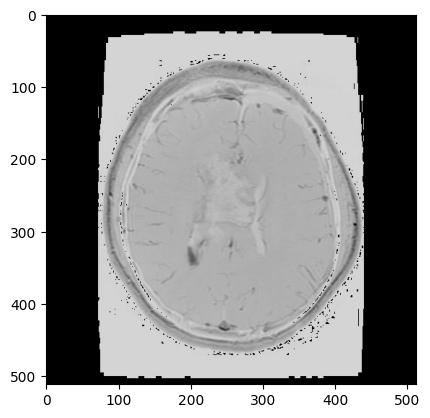

In [ ]:
first_batch = training_generator_cl[3]
img = first_batch[0][0]
plt.imshow(img)

In [ ]:
# labels
print(first_batch[1][0])

0.0


In [ ]:
#@title <b>Image Classification Model (TR VGG16)
tensorboard_dir = '/content/Mount/MyDrive/coursework/Callbacks/Tensorboard'  #@param {type:'string'}
tensorboard_callback = TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)
ealy_stopping_patience = 3 #@param {type:'number'}
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=ealy_stopping_patience,
    restore_best_weights=True
)
model_checkpoint_dir = '/content/Mount/MyDrive/coursework/Callbacks/ModelCheckpoints' #@param {type:'string'}
model_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_dir,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only = True,
    )
callbacks = [early_stopping,model_checkpoint,tensorboard_callback]

@tf.keras.saving.register_keras_serializable()
class ClModel(tf.keras.Model):
    def __init__(self,input_shape,n_units_fc1,n_units_fc2,d_rate1,d_rate2,n_classes):

        super(ClModel,self).__init__()

        self.vgg_16 = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

        for layer in self.vgg_16.layers:
            layer.trainable = False

        self.vgg_16.layers[-2].trainable = True
        self.vgg_16.layers[-3].trainable = True
        self.vgg_16.layers[-4].trainable = True

        self.flatten = Flatten()
        self.dropout1 = Dropout(d_rate1)
        self.dense1 = Dense(n_units_fc1)
        self.dropout2 = Dropout(d_rate2)
        self.out = Dense(n_classes,activation='softmax')


    def call(self,inputs,training=False):
        x = self.vgg_16(inputs)
        x = self.flatten(x)
        if training:
            x = self.dropout1(x)
        x = self.dense1(x)
        if training:
            x = self.dropout2(x)
        x = self.out(x)
        return x

input_layer = Input(shape=(img_height,img_width,3))
x = ClModel((img_height,img_width,3),n_units_fc1=128,n_units_fc2=128,d_rate1=0.3,d_rate2=0.2,n_classes=4)(input_layer)
model = tf.keras.Model(inputs=input_layer,outputs=x)
print(model.summary(expand_nested=True))

# tf.keras.utils.plot_model(model, show_shapes=True)

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 cl_model (ClModel)          (None, 4)                 31492548  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| vgg16 (Functional)         (None, 16, 16, 512)       14714688 |
||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||
|| input_2 (InputLayer)      [(None, 512, 512, 3)]     0       ||
||                                                             ||
|| block1_conv1 (Conv2D)     (None, 512, 512, 64)      1792    ||
||                                                             ||
|| block1_conv2 (Conv2D)     (None, 512, 512, 64)      36928   ||
||                                                            

In [ ]:
#@title Compiling CLModel
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy','accuracy'])

In [ ]:
#@title Training CLModel
history = model.fit(
    training_generator_cl,
    epochs=11,
    validation_data=validation_generator_cl,
    callbacks=callbacks
)

Epoch 1/11
357/357 [==============================] - ETA: 0s - loss: 0.4735 - sparse_categorical_accuracy: 0.8510 - accuracy: 0.8510 
Epoch 1: val_accuracy improved from -inf to 0.87796, saving model to /content/Mount/MyDrive/coursework/Callbacks/ModelCheckpoints
357/357 [==============================] - 4976s 14s/step - loss: 0.4735 - sparse_categorical_accuracy: 0.8510 - accuracy: 0.8510 - val_loss: 0.2847 - val_sparse_categorical_accuracy: 0.8780 - val_accuracy: 0.8780
Epoch 2/11
357/357 [==============================] - ETA: 0s - loss: 0.2029 - sparse_categorical_accuracy: 0.9258 - accuracy: 0.9258
Epoch 2: val_accuracy improved from 0.87796 to 0.91762, saving model to /content/Mount/MyDrive/coursework/Callbacks/ModelCheckpoints
357/357 [==============================] - 174s 488ms/step - loss: 0.2029 - sparse_categorical_accuracy: 0.9258 - accuracy: 0.9258 - val_loss: 0.2139 - val_sparse_categorical_accuracy: 0.9176 - val_accuracy: 0.9176
Epoch 3/11
357/357 [===================

In [ ]:
#@title Saving model
save_model_dir = '/content/Mount/MyDrive/coursework/Models/ClModel'#@param {type:'string'}
model.save(save_model_dir+'/clmodel.keras')

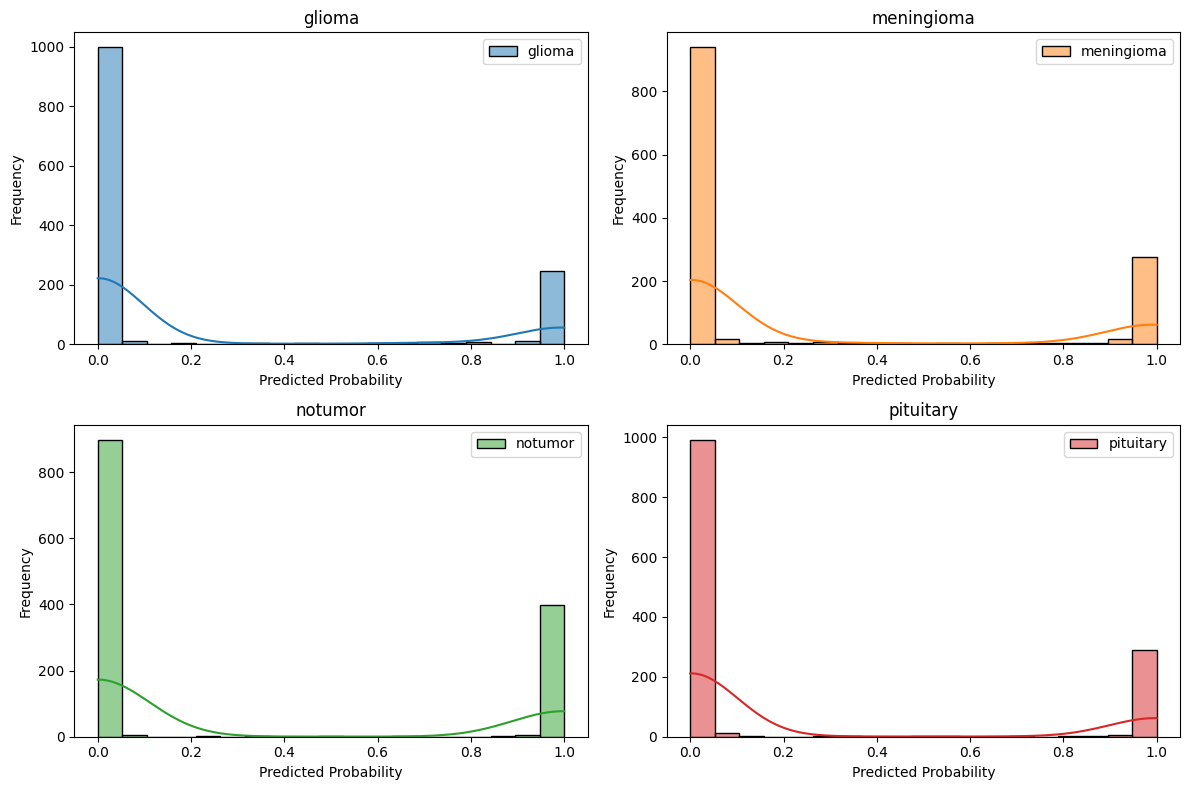

In [ ]:
#@title Histograms
cl_model = tf.keras.models.load_model('/content/Mount/MyDrive/coursework/Models/ClModel/clmodel.keras', custom_objects={"ClModel": ClModel},)
y_pred = cl_model.predict(validation_generator_cl)
y_true = validation_generator_cl.classes
n_classes = y_pred.shape[1]

# Plot histograms for each class
plt.figure(figsize=(12, 8))
bins = np.linspace(0, 1, 20)  # Define the number of bins and their range

for i,c in enumerate(class_names):
    plt.subplot(2, n_classes // 2, i + 1)
    sns.histplot(y_pred[:, i], bins=bins, kde=True, color=f'C{i}', label=c)
    plt.title(c)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 60ms/step
[0. 2. 1. 3. 3. 3. 0. 0. 1. 1. 3. 2. 2. 3. 3. 3. 2. 2. 3. 1. 0. 0. 2. 0.
 2. 2. 2. 0. 2. 2. 0. 3. 3. 2. 3. 2. 3. 1. 0. 2. 0. 0. 2. 3. 0. 3. 1. 3.
 0. 3. 0. 0. 2. 1. 3. 1. 0. 2. 1. 0. 1. 2. 1. 0. 0. 0. 2. 0. 2. 2. 2. 3.
 2. 0. 1. 0. 3. 0. 2. 1. 0. 2. 0. 3. 0. 3. 0. 3. 2. 3. 2. 3. 3. 2. 3. 0.
 1. 3. 0. 3. 0. 0. 3. 3. 1. 0. 2. 3. 2. 3. 3. 0. 3. 1. 2. 0. 3. 0. 0. 3.
 3. 3. 2. 1. 2. 2. 0. 0.]
[0. 2. 1. 3. 3. 3. 0. 0. 3. 1. 3. 2. 2. 3. 3. 3. 2. 2. 3. 1. 0. 0. 2. 0.
 2. 2. 2. 0. 2. 2. 0. 3. 3. 2. 3. 2. 3. 1. 0. 2. 0. 0. 2. 3. 0. 3. 0. 3.
 0. 3. 0. 0. 2. 1. 3. 1. 0. 2. 1. 0. 1. 2. 1. 0. 0. 0. 2. 0. 2. 2. 2. 3.
 2. 0. 1. 0. 3. 0. 2. 1. 0. 2. 0. 3. 0. 3. 0. 3. 2. 3. 2. 3. 3. 2. 3. 0.
 1. 3. 0. 3. 0. 0. 3. 3. 1. 0. 2. 3. 2. 3. 3. 0. 3. 1. 2. 0. 3. 0. 0. 3.
 3. 3. 2. 1. 2. 2. 0. 0.]


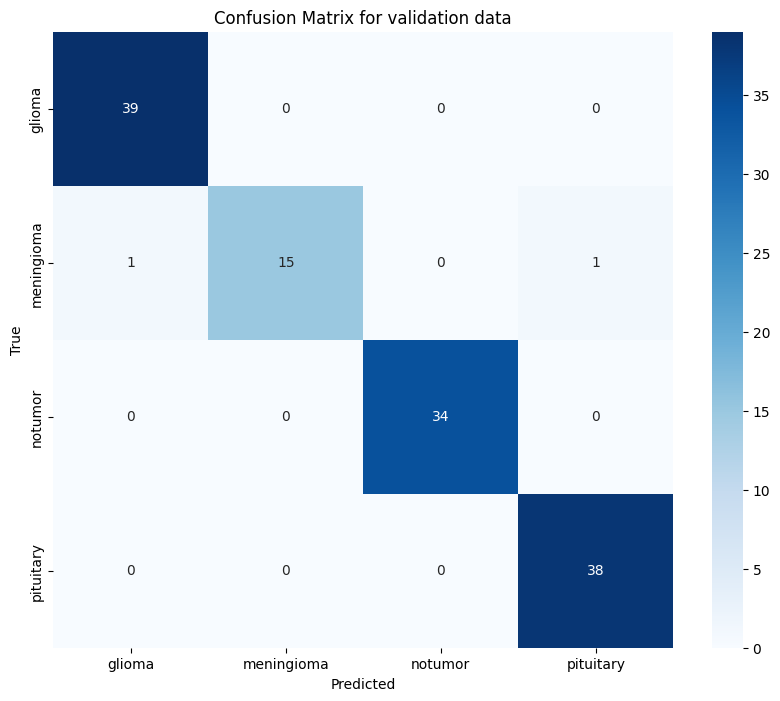

Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      1.00      0.99        39
  meningioma       1.00      0.88      0.94        17
     notumor       1.00      1.00      1.00        34
   pituitary       0.97      1.00      0.99        38

    accuracy                           0.98       128
   macro avg       0.99      0.97      0.98       128
weighted avg       0.98      0.98      0.98       128



In [ ]:
#@title Predictions
# going through batches
cl_model = tf.keras.models.load_model('/content/Mount/MyDrive/coursework/Models/ClModel/clmodel.keras', custom_objects={"ClModel": ClModel},)

y_true,y_pred=np.array([]),np.array([])
for b in range(len(validation_generator_cl)//10):
    test=validation_generator_cl[b][0]
    y_true=np.concatenate((y_true,validation_generator_cl[b][1]))
    y_pred=np.concatenate((y_pred,cl_model.predict(test).argmax(axis=1)))
print(y_true)
print(y_pred)
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator_cl.class_indices, yticklabels=validation_generator_cl.class_indices)
plt.title('Confusion Matrix for validation data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=validation_generator_cl.class_indices.keys()))

In [ ]:
#@title Possible VGG16 arch

def conv2d(filters, kernel_size, strides, activation='relu'):
    conv_model = Conv2D(filters, kernel_size, strides, activation=activation)
    return conv_model


def maxpool2d(pool_size, strides):
    maxpool2d_model = MaxPooling2D(pool_size, strides)
    return maxpool2d_model


class VGG16(tf.keras.Model):
    def __init__(self, filters: list, kernel_size=3, pool_size=2, strides_c=1, strides_p=2, padding='SAME',
                 activation='relu', n_classes=4):
        super(VGG16, self).__init__()
        self.conv1 = conv2d(filters[0], kernel_size, strides_c, activation)
        self.conv2 = conv2d(filters[1], kernel_size, strides_c, activation)
        self.maxpooling1 = maxpool2d(pool_size, strides_p)

        self.conv3 = conv2d(filters[2], kernel_size, strides_c, activation)
        self.conv4 = conv2d(filters[3], kernel_size, strides_c, activation)
        self.maxpooling2 = maxpool2d(pool_size, strides_p)

        self.conv5 = conv2d(filters[4], kernel_size, strides_c, activation)
        self.conv6 = conv2d(filters[5], kernel_size, strides_c, activation)
        self.maxpooling3 = maxpool2d(pool_size, strides_p)

        self.conv7 = conv2d(filters[6], kernel_size, strides_c, activation)
        self.conv8 = conv2d(filters[7], kernel_size, strides_c, activation)
        self.conv9 = conv2d(filters[8], kernel_size, strides_c, activation)
        self.maxpooling4 = maxpool2d(pool_size, strides_p)

        self.conv10 = conv2d(filters[6], kernel_size, strides_c, activation)
        self.conv11 = conv2d(filters[7], kernel_size, strides_c, activation)
        self.conv12 = conv2d(filters[8], kernel_size, strides_c, activation)
        self.maxpooling5 = maxpool2d(pool_size, strides_p)

        self.fc1 = tf.keras.layers.Dense(4096, activation='relu')
        self.fc2 = tf.keras.layers.Dense(4096, activation='relu')
        self.fc3 = tf.keras.layers.Dense(4096, activation='relu')

        self.out = tf.keras.layers.Dense(n_classes, activation='softmax')

    def call(self, x, *args, **kwargs):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpooling1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpooling2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.maxpooling3(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.maxpooling4(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)
        x = self.maxpooling5(x)
        x = tf.reshape(x, (tf.shape(x)[0], -1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x


def train_classifier(generator, lr=0.01, epochs=200, n_classes=4, filter_size=3, strides=1, maxpool_ksize=2,
                     filters=[64, 128, 256], fc_units=[512, 512], dropout=0.5):
    model = VGG16(filters=[64, 64, 128, 128, 256, 256, 512, 512, 512, 512], kernel_size=3, pool_size=3, strides_c=1,
                  strides_p=2, activation='relu')

    model.build(input_shape=(1, 512, 512, 3))
    model.summary()

    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

    optimizer = tf.keras.optimizers.Adam(lr)

    num_train_recs = len(generator)

    loss_trace, accuracy_trace = [], []

    start_time = time.time()

    for i in range(epochs):

        loss, accuracy = 0, 0

        for j, (train_X_batch, train_y_batch) in enumerate(generator):
            train_X_batch = tf.constant(train_X_batch, dtype=tf.float32)
            train_y_batch = tf.constant(train_y_batch)

            with tf.GradientTape() as tape:
                pred_y_batch = model(train_X_batch)
                loss_ = loss_fn(train_y_batch, pred_y_batch)

            gradients = tape.gradient(loss_, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            accuracy += np.sum(train_y_batch.numpy() == np.argmax(pred_y_batch.numpy(), axis=1))
            loss += loss_.numpy()

        loss /= num_train_recs
        accuracy /= num_train_recs
        loss_trace.append(loss)
        accuracy_trace.append(accuracy)
        print('-' * 30)
        print(f'Epoch {i + 1}: loss: {np.round(loss, 4)}, accuracy: {np.round(accuracy, 4)}\n')
        print('-' * 30)

        # if early_stopping.stopped_epoch:
        #     print('Early stopping triggered. Training stopped.')

        # tensorboard_callback.on_epoch_end(i, {'loss': loss, 'accuracy': accuracy})

    return model


model_cl = train_classifier(generator=training_generator_cl)


In [ ]:
#@title Testing Classification on Unknown Dataset
cl_model = tf.keras.saving.load_model('/content/Mount/MyDrive/coursework/Models/ClModel/clmodel.keras')

new_test_cl = ImageDataGenerator(
    preprocessing_function=augment_img
)

new_test = new_test_cl.flow_from_directory(
    directory='/content/Mount/MyDrive/coursework/Data/Datasets/Testing_new_/',
    target_size=size,
    color_mode='rgb',
    class_mode='sparse',
    shuffle=False,
)

predictions=cl_model.predict_generator(new_test)
predictions = np.argmax(predictions,axis=1)
correct_class=1
print(f'SCC: {accuracy_score(np.array([correct_class for _ in range(len(predictions))]),predictions)}')

<ipython-input-28-3b1f3a77c663>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions=cl_model.predict_generator(new_test)


SCC: 0.6666666666666666


<b><h1>Comparing to other architectures

In [ ]:
#@title <b> Classification Model (EfficientNetB0)
img_size = 512 #@param {type:'number'}
batch_size = 32 #@param {type:'number'}
efficient_net = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
x = GlobalAveragePooling2D()(efficient_net.output)
x = Dense(128,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(128,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(64,activation='relu')(x)
output_layer = Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs=efficient_net.input, outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 512, 512, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 512, 512, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 512, 512, 3)          0         ['normalization[0][0]']   

In [ ]:
#@title ClModel(EfficientNet) compilation
model.compile(loss='sparse_categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'],run_eagerly=True)

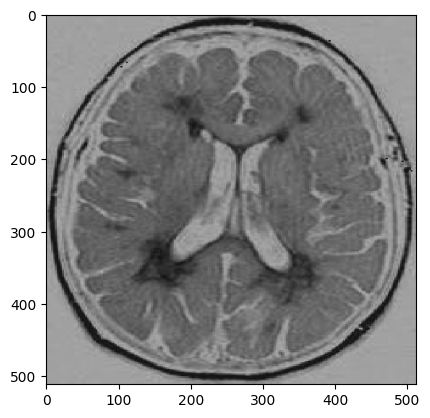

In [ ]:
first_batch = training_generator_eff[5]
img = first_batch[0][0]
plt.imshow(img)

In [ ]:
#@title Training
tensorboard_dir = '/content/Mount/MyDrive/coursework/Callbacks/EfficientNet/Tensorboard'  #@param {type:'string'}
tensorboard_callback = TensorBoard(log_dir=tensorboard_dir, histogram_freq=1)
early_stopping_patience = 3 #@param {type:'number'}
epochs = 10 #@param {type:'number'}
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=early_stopping_patience,
    restore_best_weights=True
)
model_checkpoint_dir = '/content/Mount/MyDrive/coursework/Callbacks/EfficientNet/ModelCheckpoints' #@param {type:'string'}
model_checkpoint = ModelCheckpoint(
    filepath=model_checkpoint_dir,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only = True,
    )
callbacks = [early_stopping,model_checkpoint,tensorboard_callback]
try:
    history = model.fit_generator(
        training_generator_eff,
        epochs=epochs,
        validation_data=validation_generator_eff,
        callbacks=callbacks
    )
except KeyboardInterrupt:
    efficient_net_dir = '/content/Mount/MyDrive/coursework/Models/ClModelEfficientNet' #@param {type:'string'}
    #@markdown Directory to save model in
    model.save(efficient_net_dir+'/clmodel_ef.keras')

<ipython-input-93-67af1c5690f5>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
357/357 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9371
Epoch 1: val_accuracy improved from -inf to 0.91228, saving model to /content/Mount/MyDrive/coursework/Callbacks/EfficientNet/ModelCheckpoints
357/357 [==============================] - 653s 2s/step - loss: 0.1833 - accuracy: 0.9371 - val_loss: 0.2958 - val_accuracy: 0.9123
Epoch 2/10
357/357 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9508
Epoch 2: val_accuracy improved from 0.91228 to 0.91762, saving model to /content/Mount/MyDrive/coursework/Callbacks/EfficientNet/ModelCheckpoints
357/357 [==============================] - 661s 2s/step - loss: 0.1431 - accuracy: 0.9508 - val_loss: 0.2516 - val_accuracy: 0.9176
Epoch 3/10
357/357 [==============================] - ETA: 0s - loss: 0.0956 - accuracy: 0.9646
Epoch 3: val_accuracy improved from 0.91762 to 0.94050, saving model to /content/Mount/MyDrive/coursework/Callbacks/EfficientNet/ModelCheckpoints
357/357 [====

In [ ]:
efficient_net_dir = '/content/Mount/MyDrive/coursework/Models/ClModelEfficientNet' #@param {type:'string'}
#@markdown Directory to save model in
model.save(efficient_net_dir+'/clmodel_ef.keras')

In [ ]:
loaded_model = tf.keras.saving.load_model(f'{efficient_net_dir}/clmodel_ef.keras')
y_true, y_pred = np.array([]), np.array([])

y_true,y_pred=np.array([]),np.array([])
for b in range(len(validation_generator_cl)//3):
    test=validation_generator_cl[b][0]
    y_true=np.concatenate((y_true,validation_generator_cl[b][1]))
    y_pred=np.concatenate((y_pred,loaded_model.predict(test).argmax(axis=1)))
print(y_true)
print(y_pred)
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator_eff.class_indices, yticklabels=validation_generator_eff.class_indices)
plt.title('Confusion Matrix for validation data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=validation_generator_eff.class_indices.keys()))

AttributeError: ignored

82/82 [==============================] - 41s 501ms/step


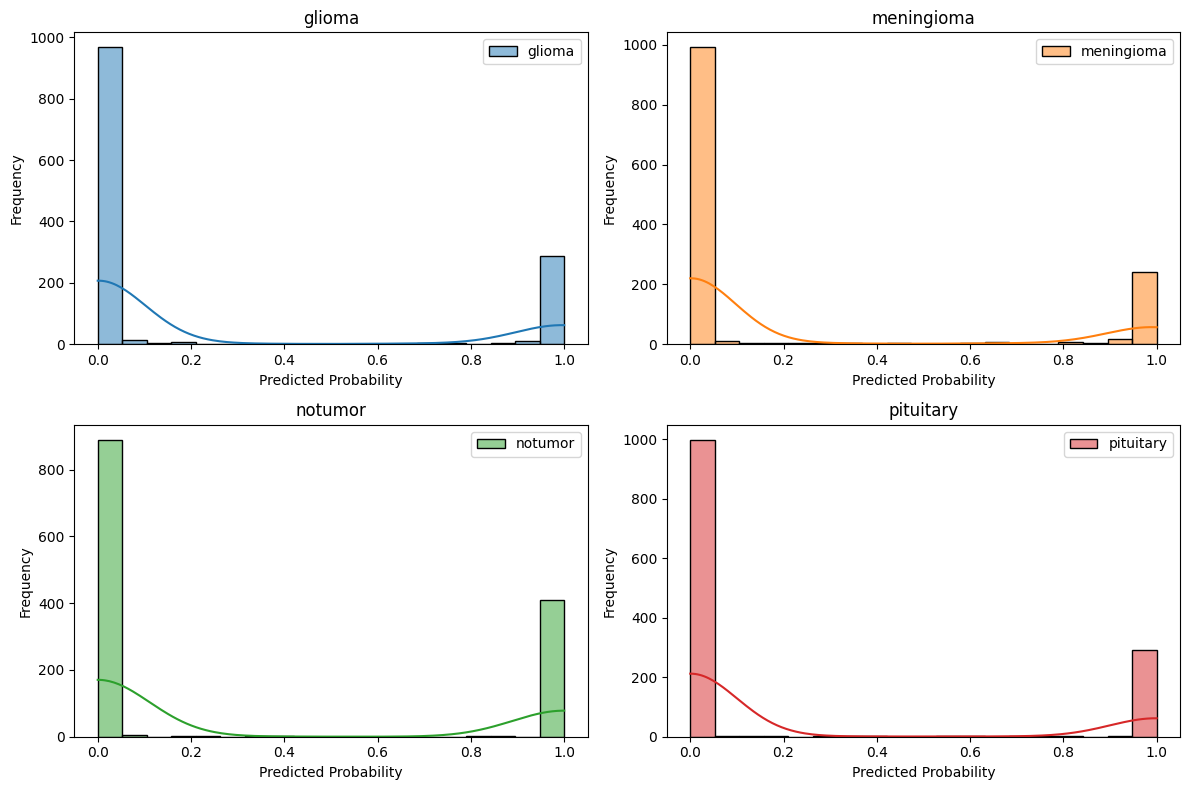

In [ ]:
#@title Histograms
y_pred = loaded_model.predict(validation_generator_cl)
y_true = validation_generator_cl.classes
n_classes = y_pred.shape[1]

# Plot histograms for each class
plt.figure(figsize=(12, 8))
bins = np.linspace(0, 1, 20)  # Define the number of bins and their range

for i,c in enumerate(class_names):
    plt.subplot(2, n_classes // 2, i + 1)
    sns.histplot(y_pred[:, i], bins=bins, kde=True, color=f'C{i}', label=c)
    plt.title(c)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()